In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from keras.utils import np_utils

# Some helper methods related to Colabs, feel free to ignore.

In [2]:
!mkdir fonts/

# Download the fonts we need.
!wget -qO Noto_Sans.zip https://drive.google.com/uc?id=1-0tqK8qCFRVqsRZag4YYJmy2ZnPOD5VD&export=download 
!unzip -qo Noto_Sans.zip -d fonts/Noto_Sans
!wget -qO Roboto.zip https://drive.google.com/uc?id=1Xo2EUtHc5CIAo3l5V1FbtRopbV7_u-Cu&export=download
!unzip -qo Roboto.zip -d fonts/Roboto
!wget -qO Poppins.zip https://drive.google.com/uc?id=18Flk0fW_8RBNmKyDJEnMA43GjFjxp-i0&export=download
!unzip -qo Poppins.zip -d fonts/Poppins

!rm Noto_Sans.zip Roboto.zip Poppins.zip

!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

# Creating the dataset.

In [3]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
read_config = tfds.ReadConfig(try_autocache=False)
data_ds = tfds.load(
  name='speech_commands',
  read_config=read_config
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteHAEF1F/speech_commands-train.tfrecord


  0%|          | 0/85511 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteHAEF1F/speech_commands-validation.tfrecord


  0%|          | 0/10102 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteHAEF1F/speech_commands-test.tfrecord


  0%|          | 0/4890 [00:00<?, ? examples/s]

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.2. Subsequent calls will reuse this data.


In [5]:
def get_processed_ds(ds, num_examples, max_len=16000, num_classes=12):
  """Get the processed dataset."""
  i = 0
  x = np.zeros([num_examples, max_len], dtype=np.float32)
  y = np.zeros([num_examples, 1], dtype=np.uint8)

  for i, example in enumerate(tfds.as_numpy(ds)):
    audio_clip = example['audio']
    label = example['label']

    # Trim and pad the audio clips to the maximum length.
    audio_clip = audio_clip[:max_len]
    audio_clip = np.pad(audio_clip, (0, max_len - audio_clip.shape[0]))
    audio_clip = np.reshape(audio_clip, (max_len)).astype(np.float32)
    
    x[i] = audio_clip
    y[i] = label
    
    # i = i + 1
    if i + 1 >= num_examples:
      break

  # STFT to extract the fourier transform on sliding windows of the input.
  # Apply STFT on the audio data, but keep only the magnitude.
  x = tf.abs(tf.signal.stft(x, frame_length=256, frame_step=128))

  # Convert the labels to a one-hot vector.
  y = np_utils.to_categorical(y, num_classes)
  return x, y

In [6]:
x_train, y_train = get_processed_ds(data_ds['train'], 16000)
x_test, y_test = get_processed_ds(data_ds['test'], 4890)

In [7]:
print(x_train.shape, y_train.shape)

(16000, 124, 129) (16000, 12)


In [8]:
print(x_test.shape, y_test.shape)

(4890, 124, 129) (4890, 12)


In [14]:
input_shape = tuple(x_train.shape.as_list()[1:])

# Setting up the model training.

In [9]:
import os

# Now let us create a callback for saving the best checkpoint so far.
# It tries to find the checkpoint with the maximum categorical accuracy.
# We will provide this to the model.fit function.

CHECKPOINTS_DIR='checkpoints'

# Create a directory for the checkpoints.
!mkdir -p $CHECKPOINTS_DIR

def best_checkpoint_callback(model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  if not os.path.exists(checkpoint_dir_path):
    os.mkdir(checkpoint_dir_path)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)


def load_best_checkpoint(model, model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  model.load_weights(checkpoint_path)
  return model

In [10]:
def base_model(
    num_classes=12,        # Number of classes in the model. 
    width_multiplier=1.0,  # Factor for scaling the network size.
    params={},             # Additional hyper-params.
):
  # Use the width_multiplier for scaling the network, the larger the value,
  # the larger the network. Keep a bound on the width though.
  w = min(max(width_multiplier, 0.05), 3.0)

  # inputs = keras.Input(shape=(16000,1))
  inputs = keras.Input(shape=input_shape)
  x = inputs

  # Create a regularizer to be used.
  reg = keras.regularizers.l2(params.get('l2_reg_weight', 2e-4))

  # Find the dropout rate for helping with further regularization.
  dropout_rate = params.get('dropout_rate', 1.0)

  # We will keep the first 'block' of layers scale invariant.
  x = layers.Conv1D(
      32, (9), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(
      32, (9), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(pool_size=(4))(x)
  x = layers.Dropout(dropout_rate)(x)

  # A short hand for the round method.
  r = lambda v: round(v)

  # We will start to scale layers from here on.
  x = layers.Conv1D(
      # Note that the number of filters grows / shrinks with `w`.
      r(64 * w), 
      (9), 
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(
      r(64 * w), 
      (9),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(pool_size=(4))(x)
  x = layers.Dropout(dropout_rate)(x)

  x = layers.Conv1D(
      r(128 * w), 
      (9),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(
      r(128 * w), 
      (9),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(pool_size=(4))(x)
  x = layers.Dropout(dropout_rate)(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(r(512 * w), activation='relu', kernel_regularizer=reg)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(num_classes, kernel_regularizer=reg)(x)
  logits = x
  probabilities = layers.Activation('softmax')(logits)
  outputs = probabilities

  return keras.Model(inputs=inputs, outputs=outputs)

In [11]:
def get_compiled_model(
    width_multiplier,
    num_classes=12,
    params={}):
  """Helper method to create the compiled model."""  
  learning_rate = params.get('learning_rate', 1e-3)

  model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt, 
                metrics='categorical_accuracy')
  return model

In [12]:
def get_model_name(width_multiplier, distillation=False):
  """A helper method to create a unique identifier for a model."""
  return 'wm_{}{}'.format(
      str(width_multiplier).replace('.', ''),
      ('_dist' if distillation else '')
  )

def train_model(width_multiplier, params={}, batch_size=128, epochs=100):
  """Train a solo model."""
  model_name = get_model_name(width_multiplier, distillation=False)

  model = get_compiled_model(
      width_multiplier=width_multiplier,
      params=params)
  model.summary()

  model_history = model.fit(
      x_train, 
      y_train, 
      batch_size=batch_size, 
      epochs=epochs, 
      validation_data=(x_test, y_test),
      callbacks=[best_checkpoint_callback(model_name)],
      shuffle=True)

  return model, model_history.history

# Training models solo.

## Train a large model with `width_multiplier`=1.0.

In [35]:
width_multiplier = 1.0
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.5,
}
model_wm_10, _ = train_model(
    width_multiplier, params, epochs=50)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 129)]        0         
                                                                 
 conv1d_12 (Conv1D)          (None, 124, 32)           37184     
                                                                 
 batch_normalization_12 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 conv1d_13 (Conv1D)          (None, 124, 32)           9248      
                                                                 
 batch_normalization_13 (Bat  (None, 124, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 31, 32)           0   

In [36]:
import tempfile

_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model_wm_10, keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpopbr4x9_.h5


# Clustering the model weights

In [37]:
! pip install -q tensorflow-model-optimization

import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

In [38]:
# Cluster a whole model
clustered_model = cluster_weights(model_wm_10, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 129)]        0         
                                                                 
 cluster_conv1d_12 (ClusterW  (None, 124, 32)          74352     
 eights)                                                         
                                                                 
 cluster_batch_normalization  (None, 124, 32)          128       
 _12 (ClusterWeights)                                            
                                                                 
 cluster_conv1d_13 (ClusterW  (None, 124, 32)          18480     
 eights)                                                         
                                                                 
 cluster_batch_normalization  (None, 124, 32)          128       
 _13 (ClusterWeights)                                      

In [39]:
# Fine-tune model
clustered_model.fit(
  x_train, 
  y_train, 
  batch_size=128, 
  epochs=1, 
  validation_data=(x_test, y_test),
  shuffle=True)

125/125 [==============================] - 7s 39ms/step - loss: 0.2502 - accuracy: 0.9685 - val_loss: 0.6145 - val_accuracy: 0.8636


## Removing the clustering variables from the final model.

In [40]:
import tempfile

final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model, clustered_keras_file, 
                           include_optimizer=False)

Saving clustered model to:  /tmp/tmphel28ysk.h5


## Exporting the clustered model as TFLite model.

In [41]:
clustered_tflite_file = '/tmp/clustered_speech.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

Saved clustered TFLite model to: /tmp/clustered_speech.tflite


# Comparing the sizes of the exported models.

In [42]:
def get_gzipped_model_size_kb(file):
  # It returns the size of the gzipped model in kb.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file) / (1024.0)

In [43]:
original_model_size_kb = get_gzipped_model_size_kb(keras_file)
clustered_model_size_kb = get_gzipped_model_size_kb(clustered_keras_file)
clustered_tflite_model_size_kb = get_gzipped_model_size_kb(clustered_tflite_file)

In [44]:
print("Size of gzipped baseline Keras model: %.2f kb" % (original_model_size_kb))
print("Size of gzipped clustered Keras model: %.2f kb" % (clustered_model_size_kb))
print("Size of gzipped clustered TFlite model: %.2f kb" % (clustered_tflite_model_size_kb))

Size of gzipped baseline Keras model: 1449.47 kb
Size of gzipped clustered Keras model: 228.07 kb
Size of gzipped clustered TFlite model: 222.21 kb


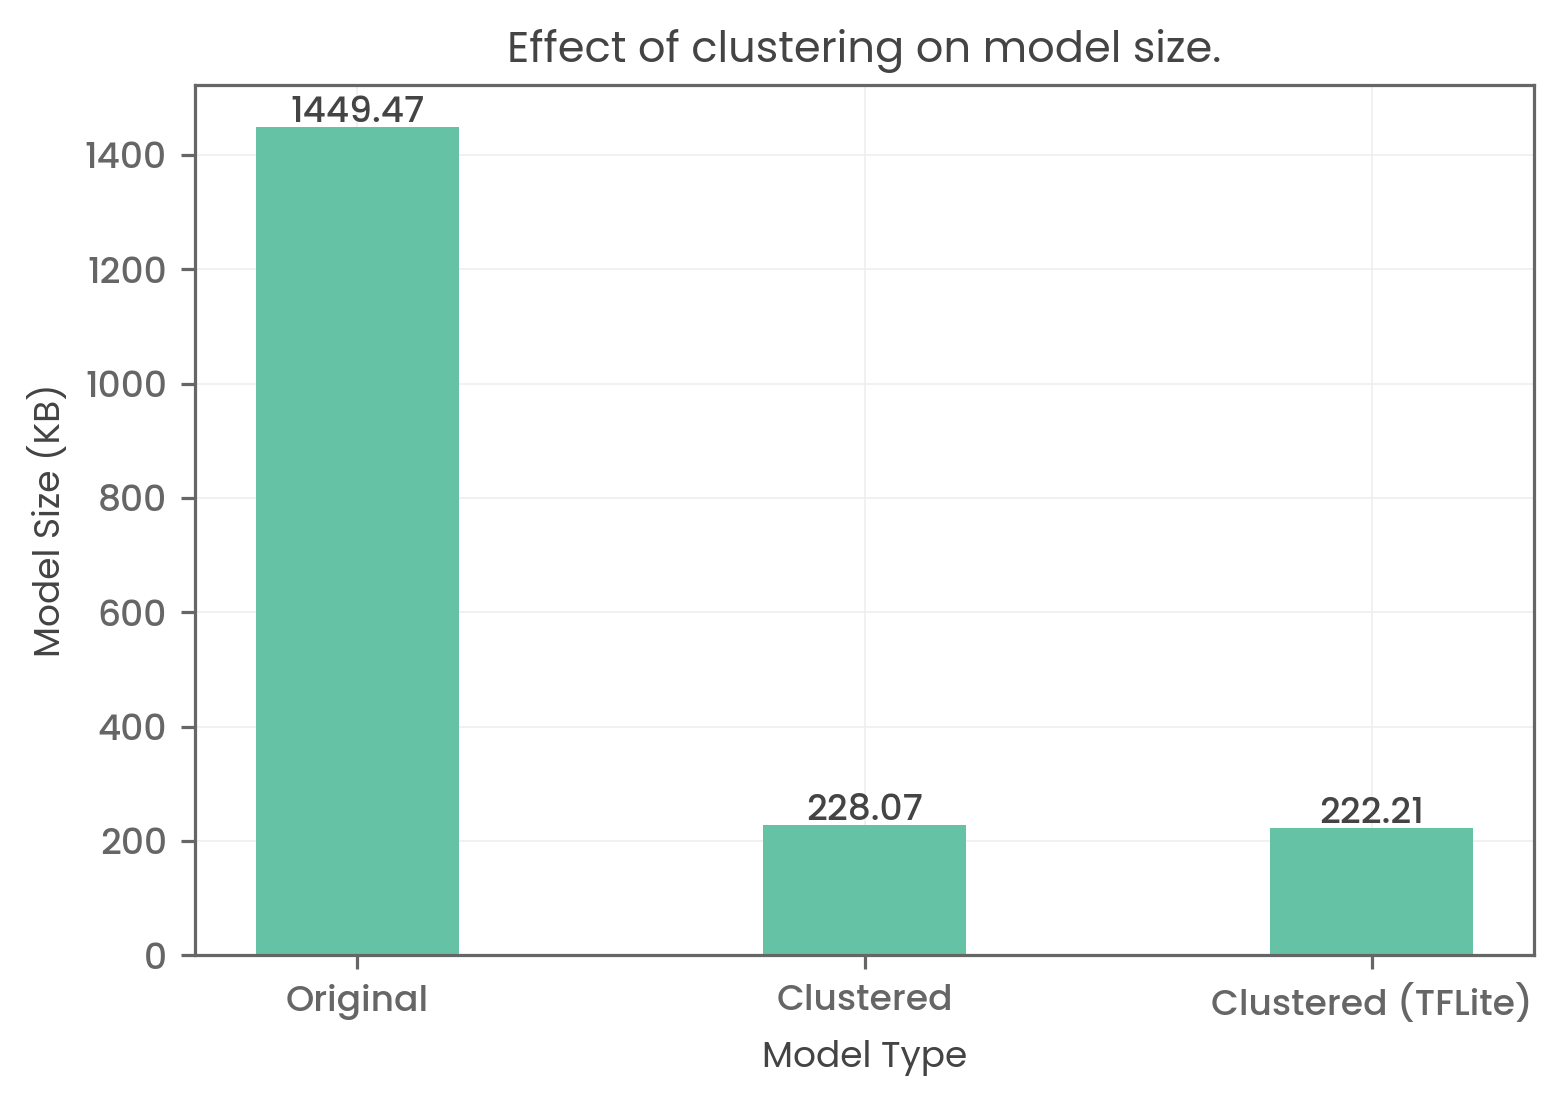

In [54]:
models = ['Original', 'Clustered', 'Clustered (TFLite)']
sizes = [original_model_size_kb, 
         clustered_model_size_kb,
         clustered_tflite_model_size_kb]
 
plt.bar(models, sizes, width=0.4)
plt.grid(visible=True)

for idx, size in enumerate(sizes):
  plt.text(idx, size + 10, f'{size:.2f}', ha='center')
 
plt.xlabel('Model Type')
plt.ylabel('Model Size (KB)')
plt.title('Effect of clustering on model size.')
plt.show()